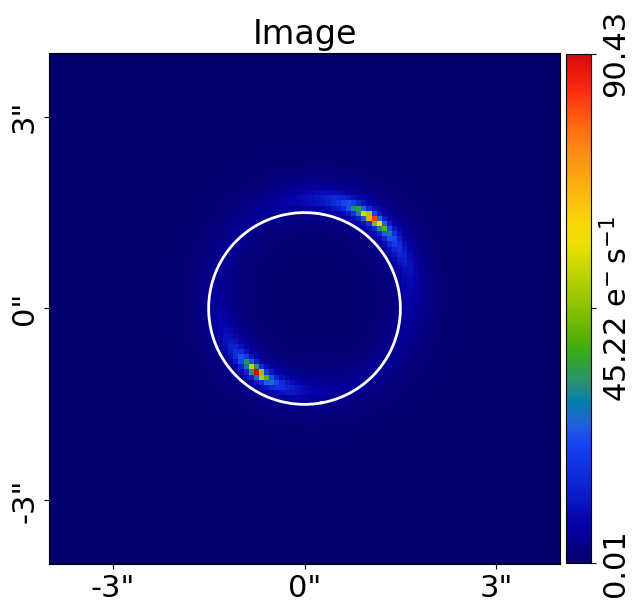

In [5]:
import autolens as al
import autolens.plot as aplt

grid = al.Grid2D.uniform(shape_native=(100,100), pixel_scales=0.08)

lens = al.Galaxy(
    redshift=0.5,
    mass=al.mp.Isothermal(centre=(0.,0.), einstein_radius=1.5)
)

source = al.Galaxy(
    redshift=2.0,
    sersic=al.lp.Sersic(centre=(0.2,0.15), intensity=0.8, effective_radius=0.7)
)

tracer = al.Tracer(galaxies=[lens, source])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

# Dark Matter Subhalo Dataset Generation

This notebook generates a labeled dataset of gravitational lensing images for training ML models to detect dark matter subhalos.

In [6]:
import numpy as np
import os
from pathlib import Path
import json

# Create directories for dataset
dataset_dir = Path("subhalo_dataset")
dataset_dir.mkdir(exist_ok=True)
(dataset_dir / "images").mkdir(exist_ok=True)
(dataset_dir / "labels").mkdir(exist_ok=True)

print(f"Dataset directory created at: {dataset_dir.absolute()}")

Dataset directory created at: /Users/janudax/Computer_Science/darkmatterml/subhalo_dataset


In [7]:
def generate_lens_system(has_subhalo=False, subhalo_params=None):
    """
    Generate a gravitational lens system with or without a subhalo.
    
    Parameters:
    -----------
    has_subhalo : bool
        Whether to include a dark matter subhalo
    subhalo_params : dict
        Parameters for the subhalo (position, mass, etc.)
    
    Returns:
    --------
    tracer : al.Tracer
        The lens system tracer
    label : dict
        Label information about the system
    """
    # Create grid
    grid = al.Grid2D.uniform(shape_native=(128, 128), pixel_scales=0.05)
    
    # Main lens galaxy with random parameters
    lens_einstein_radius = np.random.uniform(1.0, 1.8)
    lens = al.Galaxy(
        redshift=0.5,
        mass=al.mp.Isothermal(
            centre=(0.0, 0.0), 
            einstein_radius=lens_einstein_radius
        )
    )
    
    # Source galaxy with random parameters
    source_centre_y = np.random.uniform(-0.3, 0.3)
    source_centre_x = np.random.uniform(-0.3, 0.3)
    source_intensity = np.random.uniform(0.5, 1.5)
    source_radius = np.random.uniform(0.3, 0.8)
    
    source = al.Galaxy(
        redshift=2.0,
        bulge=al.lp.Sersic(
            centre=(source_centre_y, source_centre_x),
            intensity=source_intensity,
            effective_radius=source_radius,
            sersic_index=1.0
        )
    )
    
    galaxies = [lens, source]
    
    # Label dictionary
    label = {
        "has_subhalo": has_subhalo,
        "lens_einstein_radius": float(lens_einstein_radius),
        "source_centre": [float(source_centre_y), float(source_centre_x)]
    }
    
    # Add subhalo if requested
    if has_subhalo:
        if subhalo_params is None:
            # Random subhalo parameters
            subhalo_mass = np.random.uniform(1e8, 1e10)
            subhalo_y = np.random.uniform(-1.5, 1.5)
            subhalo_x = np.random.uniform(-1.5, 1.5)
        else:
            subhalo_mass = subhalo_params.get('mass', 1e9)
            subhalo_y = subhalo_params.get('centre_y', 0.5)
            subhalo_x = subhalo_params.get('centre_x', 0.5)
        
        subhalo = al.Galaxy(
            redshift=0.5,
            mass=al.mp.NFWMCRLudlowSph(
                centre=(subhalo_y, subhalo_x),
                mass_at_200=subhalo_mass
            )
        )
        galaxies.append(subhalo)
        
        label["subhalo_mass"] = float(subhalo_mass)
        label["subhalo_centre"] = [float(subhalo_y), float(subhalo_x)]
    
    tracer = al.Tracer(galaxies=galaxies)
    
    return tracer, grid, label

In [9]:
def generate_dataset(n_samples=100, subhalo_fraction=0.5):
    """
    Generate a dataset of lensing images with and without subhalos.
    
    Parameters:
    -----------
    n_samples : int
        Total number of samples to generate
    subhalo_fraction : float
        Fraction of samples that should contain subhalos (0.0 to 1.0)
    
    Returns:
    --------
    images : np.ndarray
        Array of lensing images
    labels : list
        List of label dictionaries
    """
    n_with_subhalo = int(n_samples * subhalo_fraction)
    n_without_subhalo = n_samples - n_with_subhalo
    
    images = []
    labels = []
    
    print(f"Generating {n_samples} samples ({n_with_subhalo} with subhalos, {n_without_subhalo} without)...")
    
    # Generate samples without subhalos
    for i in range(n_without_subhalo):
        tracer, grid, label = generate_lens_system(has_subhalo=False)
        image = tracer.image_2d_from(grid=grid)
        images.append(np.array(image))
        labels.append(label)
        
        if (i + 1) % 10 == 0:
            print(f"  Generated {i + 1}/{n_without_subhalo} samples without subhalos")
    
    # Generate samples with subhalos
    for i in range(n_with_subhalo):
        tracer, grid, label = generate_lens_system(has_subhalo=True)
        image = tracer.image_2d_from(grid=grid)
        images.append(np.array(image))
        labels.append(label)
        
        if (i + 1) % 10 == 0:
            print(f"  Generated {i + 1}/{n_with_subhalo} samples with subhalos")
    
    images = np.array(images)
    
    print(f"\nDataset generated!")
    print(f"  Images shape: {images.shape}")
    print(f"  Total samples: {len(labels)}")
    
    return images, labels

## Generate the dataset

Let's create a small test dataset first to verify everything works:

In [10]:
# Generate a small test dataset (increase n_samples for larger dataset)
images, labels = generate_dataset(n_samples=20, subhalo_fraction=0.5)

Generating 20 samples (10 with subhalos, 10 without)...
  Generated 10/10 samples without subhalos
  Generated 10/10 samples with subhalos

Dataset generated!
  Images shape: (20, 16384)
  Total samples: 20


## Visualize sample images

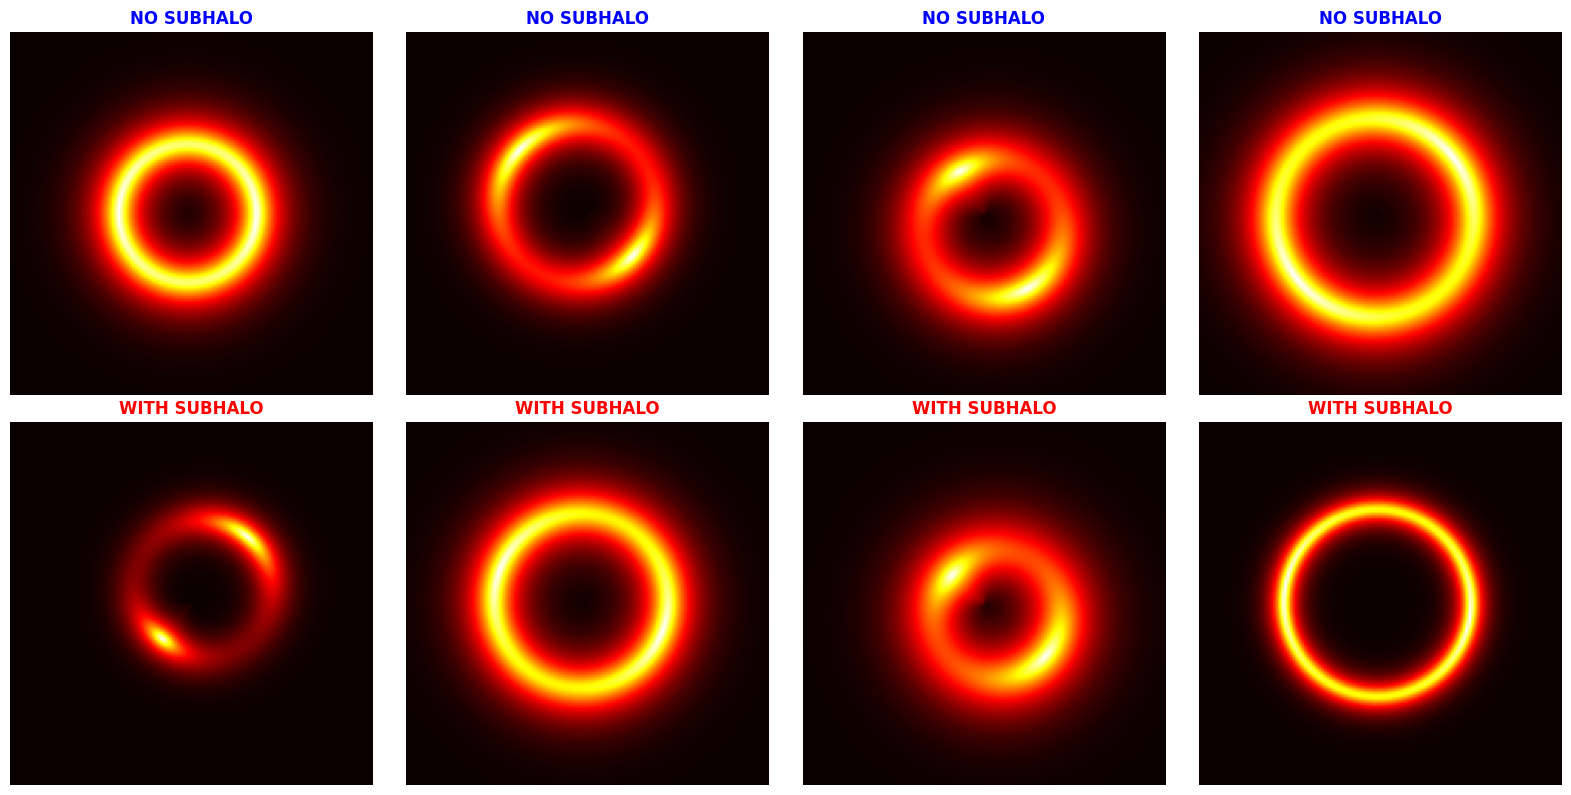


Dataset summary:
  Total samples: 20
  Without subhalos: 10
  With subhalos: 10

Sample labels with subhalos:

Sample 10 (with subhalo):
  has_subhalo: True
  lens_einstein_radius: 1.1679515109168763
  source_centre: [-0.27959637417340466, 0.23525121584464898]
  subhalo_mass: 3668130622.4879265
  subhalo_centre: [1.4642518196488603, 1.324858158223305]

Sample 11 (with subhalo):
  has_subhalo: True
  lens_einstein_radius: 1.5276573890743292
  source_centre: [-0.04643894670478077, -0.11310690693520856]
  subhalo_mass: 3344457461.9040756
  subhalo_centre: [-0.930036419343683, 0.5013929601524216]


In [16]:
import matplotlib.pyplot as plt

# Separate indices for images with and without subhalos
indices_with_subhalo = [i for i, label in enumerate(labels) if label["has_subhalo"]]
indices_without_subhalo = [i for i, label in enumerate(labels) if not label["has_subhalo"]]

# Visualize samples: top row without subhalos, bottom row with subhalos
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: without subhalos
for col in range(4):
    if col < len(indices_without_subhalo):
        idx = indices_without_subhalo[col]
        ax = axes[0, col]
        image_2d = images[idx].reshape(128, 128)
        ax.imshow(image_2d, cmap='hot', origin='lower')
        ax.set_title("NO SUBHALO", fontsize=12, fontweight='bold', color='blue')
        ax.axis('off')

# Bottom row: with subhalos
for col in range(4):
    if col < len(indices_with_subhalo):
        idx = indices_with_subhalo[col]
        ax = axes[1, col]
        image_2d = images[idx].reshape(128, 128)
        ax.imshow(image_2d, cmap='hot', origin='lower')
        ax.set_title("WITH SUBHALO", fontsize=12, fontweight='bold', color='red')
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nDataset summary:")
print(f"  Total samples: {len(labels)}")
print(f"  Without subhalos: {len(indices_without_subhalo)}")
print(f"  With subhalos: {len(indices_with_subhalo)}")

print("\nSample labels with subhalos:")
for i in range(min(2, len(indices_with_subhalo))):
    idx = indices_with_subhalo[i]
    print(f"\nSample {idx} (with subhalo):")
    for key, value in labels[idx].items():
        print(f"  {key}: {value}")

## Save the dataset

In [ ]:
# Save images as numpy array
np.save(dataset_dir / "images.npy", images)

# Save labels as JSON
with open(dataset_dir / "labels.json", 'w') as f:
    json.dump(labels, f, indent=2)

# Also create a simple CSV for quick overview
import pandas as pd
df = pd.DataFrame(labels)
df.to_csv(dataset_dir / "labels.csv", index=False)

print(f"Dataset saved to: {dataset_dir.absolute()}")
print(f"  - images.npy: shape {images.shape}")
print(f"  - labels.json: {len(labels)} samples")
print(f"  - labels.csv: summary table")
print(f"\nClass distribution:")
print(f"  With subhalo: {sum(l['has_subhalo'] for l in labels)}")
print(f"  Without subhalo: {sum(not l['has_subhalo'] for l in labels)}")

## Load dataset (for ML training)

Here's how you can load the dataset later for training your ML model:

In [ ]:
# Example: Load the dataset
loaded_images = np.load(dataset_dir / "images.npy")
with open(dataset_dir / "labels.json", 'r') as f:
    loaded_labels = json.load(f)

# Extract binary labels (has_subhalo) for classification
y = np.array([label["has_subhalo"] for label in loaded_labels], dtype=int)

print(f"Loaded images shape: {loaded_images.shape}")
print(f"Loaded labels shape: {y.shape}")
print(f"Label distribution: {np.bincount(y)}")

# You can now use loaded_images (X) and y for training
# Example with scikit-learn:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     loaded_images.reshape(len(loaded_images), -1), y, test_size=0.2
# )